# Intro

Check the readme files in the folder to learn how to run scans and use defaults vs specify parameters

# Initialize

In [ ]:
#expt_path = 'C:\\_Data\\Lairon\\2025_06_02\\'
cfg_file='smpds.yml'
expt_path = 'C:\\_Data\\SMPDs\\2025_07_05\\'
# cfg_file='lairon3.yml'

ip = '192.168.137.1'
max_t1 = 150

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from qick import QickConfig

from slab_qick_calib.exp_handling.instrumentmanager import InstrumentManager
import slab_qick_calib.experiments as meas
from slab_qick_calib.calib import qubit_tuning, measure_func
from slab_qick_calib.helpers import handy
from slab_qick_calib.calib.time_tracking import time_tracking

%load_ext autoreload
%autoreload 2

# Set color palette and font size
handy.config_figs()

## Set up new config 
Set to variables to True when setting up a new experiment config file. 

Note: make sure you set your ADC/DAC channels correctly. This code does not automatically fill in the ADC/DAC into your configuration file, so you should check yourself to make sure these values are correct. 

There are several elements that you may want to customize based on your readout parameters and coherence times. Check readme file config_manual.md

In [ ]:
# Set to false if you aren't creating a new one
new_config = False
new_folder = False

nqubits = 1
rfsoc_alias = 'Qick233'
t1_guess = 30 

import os
from slab_qick_calib.helpers import config

configs_dir = os.path.join(os.getcwd(),'../', 'configs')

cfg_file_path = os.path.join(configs_dir, cfg_file)
images_dir = os.path.join(expt_path, 'images')
summary_dir = os.path.join(images_dir, 'summary')

if new_config or new_folder:
    if new_config:
        config.init_config(cfg_file_path, nqubits, type='full', aliases=rfsoc_alias, t1=t1_guess)

    if not os.path.exists(expt_path):
        os.makedirs(expt_path)
        os.mkdir(images_dir)
        os.mkdir(summary_dir)

print('Data will be stored in', expt_path)

## Connect to RFSoC
Before running first cell, make sure a nameserver is running on the network, the Qick board is connected to it, and the ip address listed below matches that of the nameserver. 

You just need to run the first cell, then should be able to run any other cell in whatever order. 

If you need to restart the RFSoC, you should reconnect it to the nameserver and rerun this. 

In [ ]:
# Results config file
cfg_path = os.path.join(os.getcwd(),'..', 'configs', cfg_file)
auto_cfg = config.load(cfg_path)

# Connect to instruments
im = InstrumentManager(ns_address=ip)
print(im)
soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
print(soc)

cfg_dict = {'soc': soc, 'expt_path': expt_path, 'cfg_file': cfg_path, 'im': im}

## How to update config (you can also just edit yml directly)

In [ ]:
# #                                          param   value qubit #
# auto_cfg = config.update_readout(cfg_path, 'lamb', 5, qi)
# auto_cfg = config.update_qubit(cfg_path, 'f_ge', 5700, qi)

# # For multiple levels of nesting: 
# auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ge','gain'), 0.2, qi)

## Print scan params

In [ ]:
t1 = meas.T1Experiment(cfg_dict, qi=0, print=True)

In general, all scans will be interacted with either by running default, or giving arguments from params dict. 
You can run scans on list of different qubits or just one by adding first couple lines of each cell. 
Flag of update is used to decide if to set new config vals based on output of scan (if the fit looks good)

## Check QICK issues

### Check mirror frequencies on qubit

In [ ]:
from slab_qick_calib.helpers import qick_check
qick_check.check_freqs(0, cfg_dict)

### Check mirror frequencies from resonators

In [ ]:
from slab_qick_calib.helpers import qick_check
qick_check.check_resonances(cfg_dict)

### Check sampling rates and minimum point spacing

In [ ]:

fnyq = cfg_dict['soc']._get_ch_cfg(ro_ch=0)['f_dds']/2
clock_tick = 1e3*cfg_dict['soc'].cycles2us(1)
print(f'ADC Nyquist frequency is {fnyq} MHz')
print(f'1 clock tick is {clock_tick} ns')

In [ ]:
from slab_qick_calib.helpers import qick_check

# Assuming 'soc' is your QickSoc object
dac_channel = qick_check.get_ch(soc, '0_228', type='dac')
print(f'DAC channel for 0_228 is: {dac_channel}')
from slab_qick_calib.helpers.qick_check import get_ch, print_dac_channels, print_adc_channels

print_dac_channels(cfg_dict['soc'])

### Make sure you're not near the nyquist frequency of the ADC

In [ ]:
from slab_qick_calib.helpers import qick_check
qick_check.check_adc(cfg_dict)

# Time of Flight (TOF)

TOF measures the time it takes for the signal to run through the wires. It will give us the time in clock ticks that we should wait to make a measurements 

 Use this to set trig_offset in config file

In [ ]:
qubit_list = np.arange(3)
qubit_list = [0]
for qi in qubit_list:  
        tof=meas.ToFCalibrationExperiment(cfg_dict=cfg_dict, qi=qi)

        # Set frequency of choice and readout length up to 13 us
        #tof=meas.ToFCalibrationExperiment(cfg_dict=cfg_dict, qi=qi,params={'readout_length':13})#,params={'frequency':fi})

## Set trig_offset to point where signal has appeared, usually around 300-500 ns

In [ ]:
qubit_list=np.arange(3)
for qi in qubit_list: 
    auto_cfg = config.update_readout(cfg_path, 'trig_offset', 0.65, qi)

## Collect many time traces of TOF data (for examining measurement data)

check_e first prepares e state

In [ ]:
tof2d = meas.ToF2D(cfg_dict=cfg_dict, qi=qi, params={'expts_count':10000, 'readout_length': 13})
tof2d = meas.ToF2D(cfg_dict=cfg_dict, qi=qi, params={'expts_count':10000, 'readout_length': 13,'check_e':True})

# Resonator Spectroscopy 

Run resonator spectroscopy for all resonators by choosing a large frequency scan to look over. The scan will then find the different resonators and fill in the config file with their respective frequencies. In the autocalibration, there will be a finer sweep of each resonator to more accurately find its frequency. The frequencies are saved in <code>auto_cfg.device.readout.frequency</code>

## Coarse 

This will perform peak finding
Use params to specify frequency range, averaging, gain, expts. 
If gain is too high, you may be in punch out region, where resonators disappear, or above it 

In [ ]:
qi=0 # We only run this once for all qubits on a single feedline, this is a dummy value to make the scan work 
 
rspecc = meas.ResSpec(cfg_dict, qi=qi, style='coarse', progress=True, params={'start':6000, 'span':2000, 'reps':1000, 'gain':0.01, 'expts':6000})
res_values = rspecc.data['coarse_peaks']

Change prom (prominence value) to adjust how many peaks you find

In [ ]:
rspecc.analyze(peaks=True, debug=True, fit=False, prom=0.12)
rspecc.display(peaks=True, fit=False)
res_values = rspecc.data['coarse_peaks']

In [ ]:
res_values

Can delete values from res_values if they don't seem to be real res_values. 

In [ ]:
res_values = np.delete(res_values, 8)

## Fine

This will fit the resonance amplitude

Can run scan with default options, or specify your own, by commenting out different lines and editing paramters. 

### First time after running coarse scan, using res_values list
Assumes you have the same number of res_values as qubits. 
First time you run scan, plot will appear weird first because it plots the resonator frequency in the config on the same plot. Just run again

In [ ]:
update=True

num_peaks = len(res_values)

for qi in len(res_values):    
    # Used for initial finding of resonance 
    rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':5, 'center':res_values[qi]})

    if update: rspec.update(cfg_dict['cfg_file'])

### Fine resonator scan

Once the correct frequencies are saved to your config file. 

In [ ]:
update=True # Set to true if you want to update the config file with the new resonance values

# comment out one of these 
qubit_list = np.arange(3)
qubit_list=[0]

for qi in qubit_list:    
    # Manually set the span and gain 
    #rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':100, 'gain':0.01})

    # Fully automated, using previous fit to kappa to set span
    rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':'kappa'})
    if update: rspec.update(cfg_dict['cfg_file'])

### Print out scan params

In [ ]:
rspec.print()

## Resonator Power Spectroscopy 

Find a good value for gain to park your readout at until you run readout optimization. From the 2D sweep that is produced, choose a value for gain that is right before the resonator punches out. Want to choose a high value for gain because we want to be in the shot noise limited regime which increases our signal:noise ratio. 

In [ ]:
update=True

qubit_list = np.arange(3)
qubit_list=[0]

d=[]
for qi in qubit_list:
    #rpowspec=meas.ResSpecPower(cfg_dict, qi=qi)
    rpowspec=meas.ResSpecPower(cfg_dict, qi=qi, params={'rng':300,'max_gain':1, 'span':18,"f_off":4,'expts_gain':30})
    d.append(rpowspec)
    if update:
        auto_cfg = config.update_readout(cfg_path, 'lamb', rpowspec.data['lamb_shift'], qi)

### Example of plotting 2D scans for a bunch of qubits together
Can also use for varying a parameter on one qubit and plotting the results together

In [ ]:
auto_cfg = config.load(cfg_path)
horz_line = auto_cfg.device.readout.gain
handy.plot_many(d, title='Resonator Power', save_path=cfg_dict['expt_path'], chan='amps', yax='log', norm=True, horz_line=horz_line)

### Save gain values 

In [ ]:
# assign the resonator gain to the results config file
gain_values = [0.1,0.01]
for i, qi in enumerate(qubit_list):
    auto_cfg = config.update_readout(cfg_file, 'gain', gain_values[i], qi)

# Qubit Spectroscopy

## Find qubits
More automated, zooms out and adds power if no peak visible. Best to use if you're feeling confident, otherwise use more manual stuff in next cell. 

In [ ]:
qubit_list = np.arange(3)
qubit_list= [0]

bad_qubits=[]
for qi in qubit_list:
    status, ntries = qubit_tuning.find_spec(qi, cfg_dict, start='coarse')
    if not status:
        bad_qubits.append(qi)

## General search, specify width 

style options: fine, medium, coarse, huge (will change scan width and power)

Uses config values of low_gain (gain to use for finest scan), which sets overall gain for device and spec_gain (set indepedently for each qubit) to decide how much power to apply

You may also just want to do this fully manually by specifiying params. 

In [ ]:
update=True

#qubit_list = np.arange(3)
qubit_list = [0]

for qi in qubit_list: 
    # Default params, just specify style 
    #qspec=meas.QubitSpec(cfg_dict, qi=qi, style='medium')

    # Different examples of params you might give; frequency can be specified as start and span or if no start given, center is f_ge from config
    #qspec=meas.QubitSpec(cfg_dict, qi=qi, style='fine', params={'length':3})
    params={'span':3,'expts':100,'gain':0.1,'sep_readout':True, 'length':3, 'readout_length':10, 'reps':10000}
    qspec=meas.QubitSpec(cfg_dict, qi=qi, style='coarse', params=params)
    if update and qspec.status: 
        auto_cfg = config.update_qubit(cfg_path, 'f_ge', qspec.data["best_fit"][2], qi)
        auto_cfg = config.update_qubit(cfg_path, 'kappa',2*qspec.data["best_fit"][3], qi)
    elif update:
        print(f'Bad qubit! qi={qi}')

## Stark (still getting it working)

In [ ]:
qi=2
qspec=meas.StarkSpec(cfg_dict, qi=qi, style='medium', params={'df_stark':0, 'max_stark_gain':0.2, 'df':-55,'span':130, 'stark_expts':50,'stark_rng':50})

## Power sweep

In [ ]:
qubit_list=[0]

for qi in qubit_list:
    params={'start':610,'span':20,'expts':200, 'sep_readout':False, 'length':3}
    qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='', params=params)
    #qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='', params={'start':3700,'span':600,'reps':1500,'expts':1200, 'max_gain':0.4, 'length':1,'sep_readout':True})

### Sweep pulse length 
Useful when t1 low

sep_readout = False measures at same time as probe pulse (default is True)

In [ ]:
length = [1,3,5,10]
for l in length:
    for qi in qubit_list:
        qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='', params={'start':5320,'span':100,'reps':1000,'expts':200,'length':l})
        #qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='', params={'start':3700,'span':600,'reps':1500,'expts':1200, 'max_gain':0.4, 'length':1,'sep_readout':True})

### Narrow scan

In [ ]:
qq=[]

# qubit_list = np.arange(3)
qubit_list=[2]
for qi in qubit_list:
    qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='narrow')
    
    # Nice for pretty pics once you have T1 measurement. 
    #qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='fine', params={'length':'t1','max_gain':1})
    qq.append(qspec_pow)

# When measuring many qubits, can do a bunch of color plots this way
#handy.plot_many(qq, title='Qubit Power Amps 0.6-0.2', save_path=cfg_dict['expt_path'], yax='log', chan='amps')
#handy.plot_many(qq, title='Qubit Power Phase 0.6-0.2', save_path=cfg_dict['expt_path'], yax='log', chan='phases')

### Multiple wide scans looking for qubit

In [ ]:
qubit_list = np.arange(3)
qubit_list=[1]

span = 250
start_all = [2000, 3100, 3400]
end_all = [4780, 3700, 4250]
sensitivities = [0.8, 0.4, 0.2]

d = []
for qi in tqdm(qubit_list, desc='Qubit Number'):
    starts = np.arange(start_all[qi], end_all[qi], span)
    qresults = []
    for start in tqdm(starts, desc=f'Start Frequency Sweep'):
        q_res = meas.QubitSpecPower(
            cfg_dict, 
            qi=qi, 
            style='coarse', 
            params={
                'max_gain':0.8,
                'start':start,
                'span':span,
                'rng':100,
                'reps':800}
        )#,'start':3000,'span':300'})
        qresults.append(q_res)
    
    # Handy plot
    handy.plot_many_limited(
        qresults, 
        title=f'Qubit Power for qubit {qi}', 
        save_path=cfg_dict['expt_path'],
        yax='log', 
        chan='amps', 
        individial_fig_size= (6,6), 
        xlabel='Frequency (MHz)',
        sensitivity =  sensitivities[qi],
        save = False,
    )
    d.append(q_res)
    plt.show()

# Coherent scans

## Fast tuneup

Options are: 

first_time: assume we don't know t1 time,don't have single shot working

single: do single shot readout optimization 

readout: set readout frequency based on resonator fit

In [ ]:
qubit_list = np.arange(3)
qubit_list=[0,1,2]

#qubit_list=np.delete(qubit_list, [5,13])
# Worst issue with this right now is when the qubit frequency is not correct and readout is bad; gets stuck doing ramsey/spectroscopy forever. In this case, cancel it and go back to find qubits, try changing readout gain. 
plt.rcParams.update({'font.size': 11})
for qi in qubit_list: 
    qubit_tuning.tune_up_qubit(qi, cfg_dict, first_time=False, single=False, readout=True)

## Time tracking
fast = True only measures T2r and T1, otherwise does full set of scans.

In [ ]:
scan_length = 24 #  hours 

qubit_list = [0,1,2]
tt=time_tracking(qubit_list, cfg_dict,display=False,total_time=scan_length, fast=True)

## Rabi

### Amplitude

Uses gain/sigma set in pulses part of config

In [ ]:
qubit_list = np.arange(3)
qubit_list=[0]

update=True

for qi in qubit_list: 
    #amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi)
    
    # Fully customized version
    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'reps':20000})

    if update and amp_rabi.status:
        config.update_qubit(cfg_path, ('pulses','pi_ge','gain'), amp_rabi.data['pi_length'], qi)
        

#### Amp Chevron

In [ ]:
d2=[]
qubit_list = np.arange(3)
qubit_list=[0]
for qi in qubit_list: 
    #amp_rabi_chevron = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'span_f':200,'sigma':0.25,'expts_f':100,'expts':100})

    amp_rabi_chevron = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'span_f':10, 'expts_f':20})
    d2.append(amp_rabi_chevron)

#handy.plot_many(d2, title='Rabi Chevron Phase', save_path=cfg_dict['expt_path'], chan='phases')

In [ ]:
handy.plot_many(d2, title='Rabi Chevron 7864', save_path=cfg_dict['expt_path'])

In [ ]:
amp_rabi_chevron.display(plot_both=True)

#### 2 Qubit Rabi

In [ ]:
qi=[0,10]
amp_rabi = meas.Rabi_2Q(cfg_dict,qi=qi, params={'active_reset':False})

### Length -- Uses const pulses so do not use to set up pi pulses

Cannot do fast sweep with gaussian pulses due to multiplying qickparams issues; so need the "loop:True" for those, will make everything slower. 

In [ ]:
qubit_list = [2]
for qi in qubit_list: 
    # Needs to have params of sweep: length and type: cons
    #len_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'sweep':'length', 'pulse_type':'gauss','loop':True})
    len_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'sweep':'length', 'pulse_type':'const'})

#### Length Chevron

In [ ]:
qubit_list = np.arange(3)
qubit_list=[2]
for qi in qubit_list: 
    len_rabi = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'sweep':'length',"type":"const", 'sigma':0.605, 'span_f':20})
    #len_rabi = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'sweep':'length',"type":"const", 'sigma':0.205, 'expts_f':60, 'span_f':150, 'gain':0.4,'start_f':6280,'rounds':4})

## Ramsey

In [ ]:
qubit_list=[2]
update = True

for qi in qubit_list:
    t2r = meas.T2Experiment(cfg_dict, qi=qi, max_err=10)

    # Manually configured
    #t2r = meas.T2Experiment(cfg_dict, qi=qi, max_err=10, params = {'ramsey_freq':1,'expts':100, 'span':10,'start':0.01})
    if t2r.status and update:
        config.update_qubit(cfg_path, 'f_ge', t2r.data['new_freq'], qi)
        auto_cfg = config.update_qubit(cfg_path, 'T2r', t2r.data['best_fit'][3], qi, rng_vals=[1.5, max_t1], sig=2)
    else:
        print('T2 Ramsey fit failed')

### Use Ramsey to recenter

In [ ]:
qubit_list = [2]
for qi in qubit_list:
    status = qubit_tuning.recenter(qi,cfg_dict)            

### Ramsey coherence

In [ ]:
t1= qubit_tuning.get_coherence(meas.RamseyExperiment, qi, cfg_dict,par='T2r')

## T1

If it's the first time, also set T2r and T2e as guesses 


In [ ]:
update=True
first_time=False

qubit_list = np.arange(3)
qubit_list=[1]
for qi in qubit_list:
    #t1 = meas.T1Experiment(cfg_dict, qi=qi)
    t1 = meas.T1Experiment(cfg_dict, qi=qi, params={'reps':100000,'span':0, 'start':20})

    if update: t1.update(cfg_path, first_time=first_time)

### T1 coherence

Runs scan until scan is properly configured to be sensitive to T1

In [ ]:
qi=0
qubit_tuning.get_coherence(meas.T1Experiment,qi=qi,cfg_dict=cfg_dict,par='T1')

### Continuous scan at single point
Times do not seem to be accurate right now 

In [ ]:
qi=0
t1cont = meas.T1ContExperiment(cfg_dict,qi=qi, params={'shots':200000})

### T1 continuous 2Q

In [ ]:
qi = [10,0]
meas.T1_2Q(cfg_dict,qi=qi, )

In [ ]:
qi=[0,10]
scan_time = 0.1 #hours
number_of_scans = 1
shots = int(100000*scan_time*60/4)
print(shots)
for i in range(number_of_scans):
    meas.T1Cont2QExperiment(cfg_dict,qi=qi, params={'shots':shots, 'active_reset':False})

## Echo and more

  0%|          | 0/20000 [00:00<?, ?it/s]

C:\_Lib\slab_qick_calib\analysis\fitting.py:635: RuntimeWarning: overflow encountered in exp
  * np.exp(-x / decay)


R2:0.086	Fit par error:0.791	 Best fit:b'amps'
R2:0.082	Fit par error:0.605	 Best fit:b'avgq'


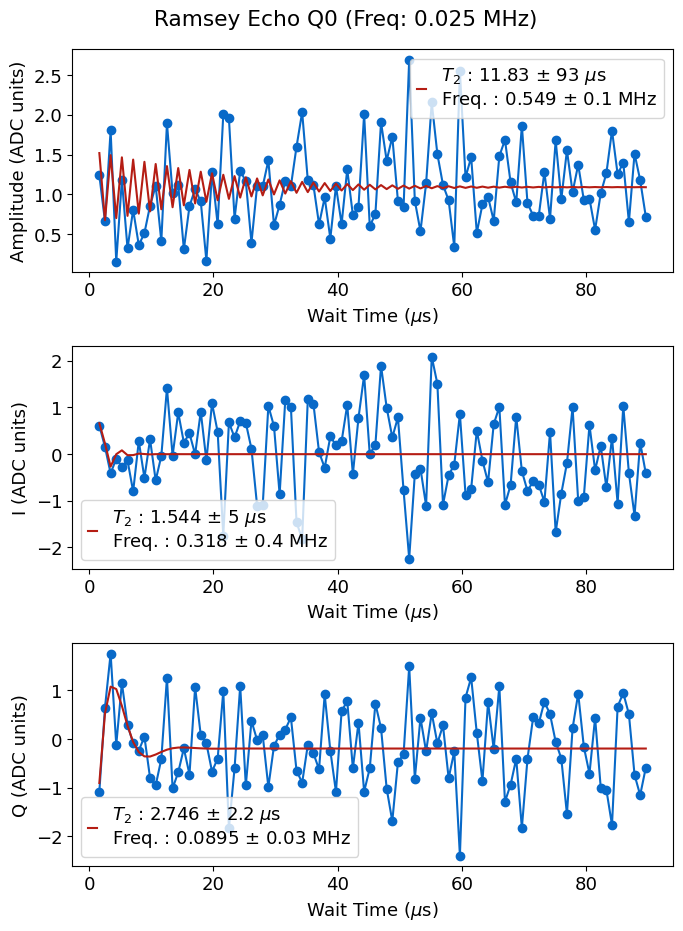

In [71]:
qubit_list = np.arange(3)
qubit_list=[0]
update=True
for qi in qubit_list:
    # Need to have experiment type set to echo
    t2e = meas.T2Experiment(cfg_dict, qi=qi, params={'experiment_type':'echo'})
    if t2e.status and update:
        auto_cfg = config.update_qubit(cfg_path, 'T2e', t2e.data['best_fit'][3], qi,sig=2, rng_vals=[1.5, max_t1*2])

### More pi / CPMG
Breaks above 12 right now; need to make it a python loop 

In [ ]:
qubit_list = np.arange(3)
qubit_list=[1]
update=True
nums_pi = [10]
for qi in qubit_list:
    for pi in nums_pi:
        # Need to have experiment type set to echo
        t2e = meas.T2Experiment(cfg_dict, qi=qi, params={'experiment_type':'cpmg','num_pi':pi,'span':100})


### Get echo coherence

In [ ]:
qi=6
t2e = qubit_tuning.get_coherence(meas.RamseyEchoExperiment, qi, cfg_dict,'T2e')

## Feedback checks

In [ ]:
qi=10
reset = meas.MemoryExperiment(cfg_dict, qi=qi, params={'shots':1, 'expts':200})

In [ ]:
# Don't do the active reset, just do the repeated measurement 
qi=1
shot = meas.RepMeasExperiment(cfg_dict, qi=qi, params={'shots':30000,'active_reset':True, 'setup_reset':True})
shot.check_reset()

# Single Shot

In [ ]:
# Single shot 
qubit_list = np.arange(3)
qubit_list =[0]

for qi in qubit_list:
    shot=meas.HistogramExperiment(cfg_dict, qi=qi)

    # Configure number of shots
    #shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':300000})
    shot.update(cfg_path)

### Adjust reps for fidelity 

In [ ]:
max_inc = 15 # dont' let it do more than 15x standard number of reps so that things don't take forever
qubit_list = [0]

auto_cfg = config.load(cfg_path)
for qi in qubit_list:
    config.update_readout(cfg_path, 'reps', 1/auto_cfg['device']['readout']['fidelity'][qi]**1.5, qi, rng_vals=[1,max_inc]);

## Readout opt

### General sweep

Runs single shot experiments for many readout lengths, frequencies, gains and compares fidelity

low_gain=True chooses lowest gain/readout length within a few percent of maximum gain (often readout fidelity fairly flat as a function of gain at higher gain values) 

style='fine' varies parameters by 20%, style='' varies by 2x

In [ ]:
update=True
low_gain=True

qubit_list=np.arange(3)
qubit_list=[0]

params = {'expts_f':1, 'expts_gain':5, 'expts_len':5,'shots':50000}
#params = {'expts_f':10, 'expts_gain':1, 'expts_len':1}

# Specify exact ranges to use  
#params = {'expts_f':1, 'expts_gain':9, 'expts_len':9,'start_gain':0.45, 'span_gain':0.05,'start_len':2, 'span_len':5}

for qi in qubit_list: 
    shotopt=meas.SingleShotOptExperiment(cfg_dict, qi=qi,params=params)#, style='fine')
    shotopt.analyze(low_gain=low_gain)
    if update: shotopt.update(cfg_dict['cfg_file'])

### Run optimization until it converges

In [ ]:
qubit_list=np.arange(3)
qubit_list=[19]
params = {'expts_f':1, 'expts_gain':7, 'expts_len':7}

# do_res also runs res spec and resets readout frequency that way each round. 
qubit_tuning.meas_opt(cfg_dict, qubit_list, params, do_res=True)

### Vary trig_offset to see if it changes fidelity. 

In [ ]:
# Single shot 
qubit_list = np.arange(3)
qubit_list =[11]
trig_list = np.linspace(0.2,1,12)
fids =[]
for qi in qubit_list:
    for trig in trig_list: 
        config.update_readout(cfg_path, 'trig_offset', trig, qi);
        shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000, 'trigger':trig})
        fids.append(shot.data['fids'][0])
    

### Play with LO freq (when using qick for LO)

In [ ]:
auto_cfg = config.load(cfg_path)
start_freq = auto_cfg.device.readout.frequency[qi]
start_mixer = auto_cfg.hw.soc.lo.mixer_freq[qi]
rng = np.linspace(-1000,1000,11)
fids=[]
for qi in qubit_list: 
    for r in rng: 
        config.update_lo(cfg_path, 'mixer_freq', start_mixer+r, qi)
        config.update_readout(cfg_path, 'frequency', start_freq-r, qi)
        shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000})
        fids.append(shot.data['fids'][0])

config.update_lo(cfg_path, 'mixer_freq', start_mixer, qi)
config.update_readout(cfg_path, 'frequency', start_freq, qi)

#### Play with LO power

In [ ]:
qi = 0
gain_vals = [0.0375,0.05] 
fids = []
for gain in gain_vals:
    config.update_lo(cfg_path, 'gain', gain, qi)
    shotopt=meas.SingleShotOptExperiment(cfg_dict, qi=qi,params={'npts_f':5, 'npts_gain':5, 'npts_len':5})
    fids.append(shot.data['fids'][0])

## Active reset

### Check active reset at standard threshold

Setup reset uses the calibrated angle and runs active reset process at end, but also uses usual final_delay so that it's ok if reset not working

In [ ]:
qubit_list = np.arange(3)
qubit_list=[0,1,2]
d=[]
for qi in qubit_list:
    shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':30000,'active_reset':True, 'setup_reset':True})
    shot.check_reset()
    #config.update_readout(cfg_path, 'reset_e', shot.data['reset_e'], qi)
    #config.update_readout(cfg_path, 'reset_g', shot.data['reset_g'], qi)
    d.append(shot)

### Sweep threshold

In [ ]:
d = []
qi=10
auto_cfg = config.load(cfg_path)
threshold = auto_cfg['device']['readout']['threshold'][qi]
thresh = np.linspace(threshold-25,threshold+25,16)
#thresh = np.linspace(threshold-10,threshold+10,6)
for t in thresh:
    shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':100000,'threshold_v':t, 'active_reset':True,'setup_reset':True}, display=False, progress=False)
    d.append(shot)
    #shot.check_reset()
measure_func.plot_reset(d)

### Turn off active reset for all config chans

In [ ]:
for qi in range(20):
    config.update_readout(cfg_path, 'active_reset',False, qi)

### Turn on active reset for channels where it seems to be working

In [ ]:
e_success = 0.15 # Ratio of e proportion after active reset compared to before
g_vs_e = 2 # Ratio of g proportion to e proportion after active reset

auto_cfg = config.load(cfg_path)
reset_e = auto_cfg['device']['readout']['reset_e']
reset_g = auto_cfg['device']['readout']['reset_g']
result = np.array(reset_e)< e_success | np.array(reset_g)/np.array(reset_e)<g_vs_e
for qi in range(20):
    config.update_readout(cfg_path, 'active_reset',bool(result[qi]), qi)

### Check reset (plotting result of reset)

In [ ]:
qubit_list = np.arange(3)
qubit_list =[17]
for qi in qubit_list:
    shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':50000,'active_reset':True})
    shot.check_reset()

# Chi

In [ ]:
# Need a tuned up pi pulse for this

qubit_list = [1]
for qi in qubit_list: 
    chi, chi_val=measure_func.check_chi(cfg_dict, qi)
    auto_cfg = config.update_readout(cfg_path, 'chi', chi_val, qi)

# 2 Qubit

In [ ]:
t12q = meas.T1_2Q(cfg_dict, qi=[10,0], params={'active_reset':False, })

In [ ]:
rabi2q = meas.Rabi_2Q(cfg_dict, qi=[10,0], params={'active_reset':True})

# EF 

### Initial setting of frequencies based on guess for alpha

In [ ]:
# Initial set of the frequencyies based on guess for alpha 
alpha = -150
#qubit_list = np.arange(3)
qubit_list = [1,2]
auto_cfg = config.load(cfg_path)
for i in qubit_list: 
    f_ge = auto_cfg['device']['qubit']['f_ge'][i]
    auto_cfg = config.update_qubit(cfg_path, 'f_ef', f_ge+alpha, i)

## Spectroscopy EF

### General search

In [ ]:
qubit_list= np.arange(3)
bad_qubits=[]
qubit_list=[0,1,2]
for qi in qubit_list:
    status, ntries = qubit_tuning.find_spec(qi, cfg_dict, start='medium', freq='ef')
    if not status:
        bad_qubits.append(qi)

### Specific width

In [ ]:
# You may want to update this frequency, which will be the center of the scan. 
#style huge, coarse, medium, fine 
update=True

qubit_list = np.arange(3)
qubit_list=[2]
for qi in qubit_list:
    qspec=meas.QubitSpec(cfg_dict, qi=qi, style='coarse', params={'checkEF':True, 'gain':1,'reps':2000})#, params={'span':500, 'expts':1000,'reps':500,'gain':0.2})

    #qspec=meas.QubitSpec(cfg_dict, qi=qi, style='medium', params={'checkEF':True})#, params={'span':500, 'expts':1000,'reps':500,'gain':0.2})
    if update and qspec.status:
        auto_cfg = config.update_qubit(cfg_path, 'f_ef', qspec.data["best_fit"][2], qi)

## Rabi EF

In [ ]:
# If first time, initialize the sigma and gain to those of the ge 
first_time =False
update = True

qubit_list = np.arange(3)
qubit_list=[0,1,2]

bad_qubits = []
auto_cfg = config.load(cfg_path)

for qi in qubit_list: 
    if first_time:
        #config.update_qubit(cfg_path, 'f_ef', auto_cfg.device.qubit.f_spec_ef[qi], qi)
        auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ef','sigma'), auto_cfg['device']['qubit']['pulses']['pi_ge']['sigma'][qi], qi)
        auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ef','gain'), auto_cfg['device']['qubit']['pulses']['pi_ge']['gain'][qi], qi)
    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'checkEF':True})
    if update and amp_rabi.status:
        config.update_qubit(cfg_path, ('pulses','pi_ef','gain'), amp_rabi.data['pi_length'], qi)
    else:
        print(f'Amplitude Rabi fit failed for qubit {qi}')
        bad_qubits.append(qi)

## Qubit Temperature

In [ ]:
qubit_list = np.arange(3)
qubit_list=[0,1,2]
for qi in qubit_list: 
    # rounds will make scan take longer, needed for lower temperatures. 
    temp, pop = measure_func.measure_temp(cfg_dict, qi=qi)# , rounds=5)
    auto_cfg = config.update_qubit(cfg_path, 'temp', temp, qi)
    auto_cfg = config.update_qubit(cfg_path, 'pop', pop, qi)

## Calculate Ec and Ej

In [ ]:
auto_cfg = config.load(cfg_path)
import scqubits as scq
for i in np.arange(3):
    alpha =  auto_cfg.device.qubit.f_ef[i] - auto_cfg.device.qubit.f_ge[i]
    en = scq.Transmon.find_EJ_EC(auto_cfg.device.qubit.f_ge[i]/1000,alpha/1000)
    print(alpha)
    print(en)
    q = np.pi*2 * auto_cfg.device.qubit.f_ge[i] * auto_cfg.device.qubit.T1[i]
    print(q)

## Ramsey EF

In [ ]:
update=True
qubit_list=np.arange(3)
#qubit_list=[12]

for qi in qubit_list:
    t2r = meas.T2Experiment(cfg_dict, qi=qi, params={'ramsey_freq':0.15, 'checkEF':True})

    if update and t2r.status:
        config.update_qubit(cfg_path, 'f_ef', t2r.data['new_freq'], qi)
    else:
        print('T2 Ramsey fit failed')

# Stark

## Ramsey

### Single experiment

In [ ]:
qi=0
meas.RamseyStarkExperiment(cfg_dict, qi=qi, params={'stark_gain':0.0,'step':0.1,'df':200,'acStark':True,'ramsey_freq':0.1})

### Sweep frequency

In [ ]:
qubit_list = np.arange(3)
qubit_list=[3]

gain = np.linspace(0.1,1,10)
for qi in qubit_list:
    for g in gain:
        t2rstark=meas.RamseyStarkFreqExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'stark_gain':g, 'start_df':30, 'end_df':150, 'expts_df':10})

### Calibrate stark power positive freq

In [ ]:
qubit_list = np.arange(3)
qubit_list=[19]
d=[]
freqs= [200]
for f in freqs:
    for qi in qubit_list:
        t2rstark=meas.RamseyStarkPowerExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'expts_gain':12, 'df':f, 'start_gain':0.1, 'end_gain':1})
        d.append(t2rstark)
        config.update_stark(cfg_path, 'q', t2rstark.data['quad_fit'][0], qi)
        config.update_stark(cfg_path, 'l', t2rstark.data['quad_fit'][1], qi)
        config.update_stark(cfg_path, 'o', t2rstark.data['quad_fit'][2], qi)

In [ ]:
plt.figure()
for i in range(len(t2rstark.data['bin_centers'])):
    plt.plot(t2rstark.data['bin_centers'][i], t2rstark.data['hist'][i])

### Negative frequency

In [ ]:
#qubit_list = np.arange(3)
d=[]
qubit_list=[19]
for qi in qubit_list:
    t2rstark=meas.RamseyStarkPowerExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'expts_gain':12, 'df':-100, 'start_gain':0.08, 'end_gain':0.35, 'rounds':2})
    d.append(t2rstark)
    config.update_stark(cfg_path, 'qneg', t2rstark.data['quad_fit'][0], qi)
    config.update_stark(cfg_path, 'lneg', t2rstark.data['quad_fit'][1], qi)
    config.update_stark(cfg_path, 'oneg', t2rstark.data['quad_fit'][2], qi)
#handy.plot_many(d, title='Ramsey Stark', save_path=cfg_dict['expt_path'])

## T1

### Single exp

In [ ]:
qi=0
gain_list = [1]
for g in gain_list:
    t1 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':g,'expts':300,'start':10,'span':0,'reps':100000}) 

### Gain sweep

In [ ]:
qubit_list = np.arange(3)
qubit_list=[0]
flist=[210,180]
for f in flist:
    for qi in qubit_list: 
        #t1_neg = meas.T1StarkPowerExperiment(cfg_dict, qi=qi, params={'df':-70,'start_gain':0.02,'end_gain':0.2,'start':3, 'rounds':4})

        t1_pos = meas.T1StarkPowerExperiment(cfg_dict, qi=qi, params={'df':f,'start_gain':0.3,'end_gain':1,'start':0.2, 'rounds':1,'span':0.5,'expts_gain':80}) 
        plt.figure()
        for i in range(len(t1_pos.data['bin_centers'])):
            plt.plot(t1_pos.data['bin_centers'][i], t1_pos.data['hist'][i])

### Freq sweep

In [ ]:
t1_freq = meas.T1StarkFreqExperiment(cfg_dict, qi=19, params={'span':6, 'span_f':100, 'start_df':50, 'expts_f':100})

### Single evo point linear gain sweep

In [ ]:
t1_cont = meas.T1StarkPowerSingle(cfg_dict, qi=0, params={"rounds":4})